# Assignment 2

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2023, Utrecht University*

Total points: 10 + 1 bonus

Deadline: Friday 29 September, 23:59

**Write your names and student numbers here: _Vincent van Akker(6425316) and Noortje Peeters (7982356)**

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

## Coin Flipping
In this second assignment, you're going to see how some of the central concepts from Bayesian machine learning behave in different scenarios. You'll be looking at the coin flipping example that has also taken a central place in the book and the lectures so far.

When flipping a coin $N$ times, under very reasonable assumptions, the probability of getting $y$ times heads is given by the binomial distribution with parameters $N$ and $r$, where $r$ is the probability that the coin lands heads on one flip.

SciPy includes functions for working with many well-known distributions, allowing you to sample from them and compute probabilities and densities, as well as many other properties. For the binomial distribution, you can compute the probability of getting $y$ heads with `binom.pmf(y, N, r)`.

**Task 1** (1 point): For the values $r = 0.00, 0.01, \ldots, 1.00$, compute the likelihood of seeing 9 out of 10 heads, and plot these in a graph.

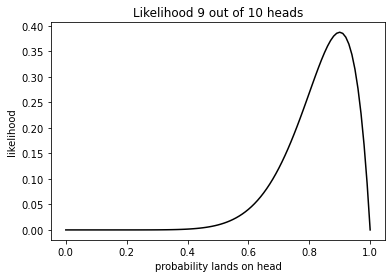

In [93]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import binom, beta
import scipy.special as sps

# Use np.linspace to get a NumPy array of evenly spaced values for r.

# YOUR CODE HERE
r = np.linspace(0.00, 1.00, 101)
p = []
N = 10
y = 9
for i in range(len(r)):
    p_i = binom.pmf(y, N, r[i])
    p.append(p_i)
plt.plot(r, p, c='black')
plt.title("Likelihood 9 out of 10 heads")
plt.xlabel("probability lands on head")
plt.ylabel("likelihood")
plt.show()

### Predictors

We will define three different "predictor" classes. The first will use maximum likelihood to make its predictions, the other two will use a Bayesian approach, with different kinds of priors. Each predictor object will have the following functions:

* `predictor.updated(num_heads, N)` returns a new predictor object. This predictor object copies the information from the original predictor object `self`, but updated with the information that `N` additional new data points have been seen, `num_heads` of which were heads.

* `predictor.predict()` returns a number between 0 and 1, which is the probability that this predictor assigns to the next coin flip coming up heads.

* `predictor.marginal_likelihood(num_heads, N)` returns the Bayesian marginal likelihood. This is only defined for Bayesian predictors; for other types, it returns `np.nan` ("not a number").

The definition of the `MaximumLikelihoodPredictor` predictor class is given below (you don't need to change it), with some testing code to see it in action. It computes the maximum likelihood estimator for the probability that the coin lands heads, and uses this value as its prediction of how likely the next coin is to land heads.

In [94]:
class MaximumLikelihoodPredictor:
    def __init__(self):
        self.num_heads = 0
        self.N = 0
    def __str__(self):
        return f"MaximumLikelihoodPredictor with num_heads = {self.num_heads}, N = {self.N}"
    def updated(self, num_heads, N):
        after = MaximumLikelihoodPredictor()
        after.num_heads += num_heads
        after.N += N
        return after
    def predict(self):
        return self.num_heads / self.N
    def get_marginal_likelihood(self, num_heads, N):
        return np.nan
    def plot(self):
        pass

# ██████████ TEST ██████████
predictor = MaximumLikelihoodPredictor()
print("Before:", predictor)
# After two flips, both heads, you should get:
# After: MaximumLikelihoodPredictor with num_heads = 2, N = 2
# which should predict that the next flip will land heads with probability 1.0
predictor_after = predictor.updated(2, 2)
print("After:", predictor_after)
print("prediction =", predictor_after.predict())

Before: MaximumLikelihoodPredictor with num_heads = 0, N = 0
After: MaximumLikelihoodPredictor with num_heads = 2, N = 2
prediction = 1.0


The two Bayesian predictor classes will be defined next. The first will use a discrete prior: instead of considering the entire range from 0 to 1 (containing infinitely many numbers) as possible values for $R$, it will only consider some finite set of such numbers. It assigns some probability to each of them, and these probabilities add up to 1. This finite set and the associated probabilities can be represented in Python by a dictionary, that maps a value $r$ to the probability assigned to it by the prior. For example, `prior.probability_for_r[.5] = .2` means that $P(R = .5) = .2$.

Being a Bayesian predictor, the `updated` function will use Bayes' theorem to compute the posterior distribution after having seen the data. For a discrete prior, the posterior will assign probability to the same set of values of $r$, but the probabilities assigned will usually be different.

**Task 2** (1 point): Complete the implementation of the `updated` function below. (You'll finish the other incomplete functions in later tasks.) You can use the provided testing code to see if the posterior looks as it should.

In [95]:
class DiscretePriorPredictor:
    def __init__(self):
        self.probability_for_r = {}
    def __str__(self):
        return ("DiscretePriorPredictor with "
                + "; ".join([f"P(R = {r:.4f}) = {prior_prob:.4f}"
                             for r, prior_prob in self.probability_for_r.items()]))
    def updated(self, num_heads, N):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling updated")
        posterior = DiscretePriorPredictor()
        total_prob = 0.0
        for r, prior_prob in self.probability_for_r.items():
            # Compute the value in the numerator of Bayes' theorem, and
            # assign it to posterior.probability_for_r[r]
            
            # YOUR CODE HERE FOR TASK 2
            likelihood = binom.pmf(num_heads, N, r)
            numerator = likelihood * prior_prob
            posterior.probability_for_r[r] = numerator
            total_prob += numerator
        # Finaly, divide everything by the sum. The sum is cast to a numpy float
        # to avoid division-by-zero errors (numpy gives warnings instead).
        for r, posterior_prob in posterior.probability_for_r.items():
            posterior.probability_for_r[r] /= np.float64(total_prob)
        return posterior
    def predict(self):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling predict")
            
        # YOUR CODE HERE FOR TASK 3
        total_pred = 0.0
        for r, posterior_prob in self.probability_for_r.items():
            total_pred += r * posterior_prob
        return total_pred

    def get_marginal_likelihood(self, num_heads, N):
        if not len(self.probability_for_r):
            raise ValueError("assign probabilities for DiscretePriorPredictor before calling get_marginal_likelihood")
            
        # YOUR CODE HERE FOR TASK 4
        tot_marg_likelihood =0
        for r, prior_prob in self.probability_for_r.items():
            likelihood = binom.pmf(num_heads, N, r)
            tot_marg_likelihood += likelihood * prior_prob
        return tot_marg_likelihood
    
    def plot(self):
        plt.figure()
        for r, prior_prob in self.probability_for_r.items():
            plt.vlines(r, 0, prior_prob, colors='black', linestyles='solid')
        plt.xlim(-0.05, 1.05)
        plt.ylim(0, 1.1)
        plt.xlabel('R')
        plt.ylabel('Probability')
        plt.title('Probability Distribution')
        plt.show()
        
        pass
# ██████████ TEST ██████████
discrete_prior = DiscretePriorPredictor()
discrete_prior.probability_for_r[1/3] = 1/2
discrete_prior.probability_for_r[2/3] = 1/2
print("Prior:", discrete_prior)
# After two flips, both heads, you should get:
# Posterior: DiscretePrior with P(R = 0.3333) = 0.2000; P(R = 0.6667) = 0.8000,
# which should predict that the next flip will land heads with probability 0.6.
# The marginal likelihood for these data and prior should be ~ 0.2777.
discrete_posterior = discrete_prior.updated(2, 2)
print("Posterior:", discrete_posterior)
print("prediction =", discrete_posterior.predict())
print("marginal likelihood =", discrete_prior.get_marginal_likelihood(2, 2))

Prior: DiscretePriorPredictor with P(R = 0.3333) = 0.5000; P(R = 0.6667) = 0.5000
Posterior: DiscretePriorPredictor with P(R = 0.3333) = 0.2000; P(R = 0.6667) = 0.8000
prediction = 0.5999999999999999
marginal likelihood = 0.2777777777777778


The Bayesian predictive distribution is the distribution over a new coin flip, conditioned on the data. Calling the `predict` function on the posterior should output the probability $P(\text{new flip = heads} | \text{previous data})$. You saw how to compute it on the final slide of lecture 5.

**Task 3** (1 point): Implement the `predict` function above.

Finally, the marginal likelihood is the quantity that occurs in the denominator of Bayes' Theorem. In this case, the prior is discrete, so the marginal likelihood is given by a sum.

The marginal likelihood is *not conditioned on the data*. In our code, the `posterior` object (computed by `updated`) can tell us things that involve conditioning on the data. But for the marginal likelihood, we'll need to original `prior` object. You'll see that the testing code calls `prior.get_marginal_likelihood`, not `posterior.get_marginal_likelihood`.

**Task 4** (0.5 points): Implement the `get_marginal_likelihood` function above.

**Task 5** (1 point): Implement the function `plot` function above that visualises a `DiscretePriorPredictor` using vertical lines whose height denotes the probability attached to some value of $r$: something like [this figure from Wikipedia](https://en.wikipedia.org/wiki/Discrete_uniform_distribution#/media/File:Uniform_discrete_pmf_svg.svg). Use `plt.vlines`. Set the horizontal axis to run from -0.05 to 1.05. The code below calls your function to plot the prior and the posterior from the test code above.

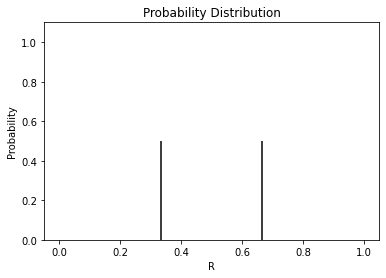

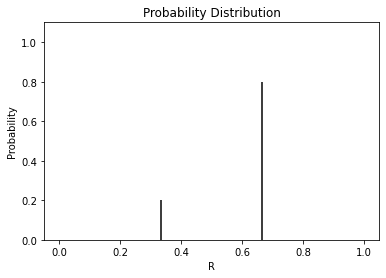

In [96]:
discrete_prior.plot()
discrete_posterior.plot()

The final predictor class will use the Beta distribution. This is a continuous prior that considers all values of $r$ between 0 and 1. Being the conjugate prior for the binomial likelihood gives it some major computational advantages.

**Task 6** (1 point): Implement `updated` and `predict` below for the `BetaPriorPredictor`.

In [97]:
class BetaPriorPredictor:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    def __str__(self):
        return f"BetaPriorPredictor with alpha = {self.alpha:.4f}, beta = {self.beta:.4f}"
    def updated(self, num_heads, N):
        # YOUR CODE HERE FOR TASK 6
        posterior = BetaPriorPredictor(self.alpha, self.beta)
        alpha = self.alpha + num_heads
        beta = self.beta + N - num_heads
        posterior.alpha = alpha
        posterior.beta = beta

        
        return posterior # CHANGE THIS
    def predict(self):
        # YOUR CODE HERE FOR TASK 6
        pred = self.alpha / (self.alpha + self.beta)
        
        return pred # CHANGE THIS
    def get_marginal_likelihood(self, num_heads, N):
        if self.alpha < 1e-9 or self.beta < 1e-9:
            return np.nan
        # The Gamma function may output really large numbers. To avoid
        # numerical inaccuracy, the following code works with logarithms instead,
        # converting back to the actual number when all Gamma's have been combined.
        return (sps.binom(N, num_heads)
                * math.exp(math.lgamma(self.alpha + self.beta)
                           - math.lgamma(self.alpha)
                           - math.lgamma(self.beta)
                           + math.lgamma(self.alpha + num_heads)
                           + math.lgamma(self.beta + N - num_heads)
                           - math.lgamma(self.alpha + self.beta + N)
                          )
               )
    def plot(self):
        # YOUR CODE HERE FOR TASK 7
        r = np.linspace(0.00, 1.00, 101)
        p = []
        q = []   #moet eruit
        for i in range(len(r)):
            p_i = beta.pdf(r[i], self.alpha, self.beta)
            p.append(p_i)
        plt.plot(r, p, c='black')
        
#         Dit klopt nog niet
#         plt.title("Beta prior predictor")
#         plt.xlabel("Probability lands on head")
#         plt.ylabel("Likelihood")
        plt.show()
        
        
        pass

# ██████████ TEST ██████████
beta_prior = BetaPriorPredictor(1, 1)
print("Prior:", beta_prior)
# After two flips, both heads, you should get:
# Posterior: BetaPrior with alpha = 3.0000, beta = 1.0000
# which should predict that the next flip will land heads with probability 0.75
# The marginal likelihood for these data and prior should be ~ 0.3333.
beta_posterior = beta_prior.updated(2, 2)
print("Posterior:", beta_posterior)
print("prediction =", beta_posterior.predict())
print("marginal likelihood =", beta_prior.get_marginal_likelihood(2, 2))

Prior: BetaPriorPredictor with alpha = 1.0000, beta = 1.0000
Posterior: BetaPriorPredictor with alpha = 3.0000, beta = 1.0000
prediction = 0.75
marginal likelihood = 0.3333333333333331


**Task 7** (0.5 points): Write a function that visualises a `BetaPriorPredictor` by plotting its probability density function. You can use the `beta` object from `scipy.stats`, which has already been imported. The code below will plot the prior and the posterior from the test code above.

In [48]:
beta_prior.plot()
beta_posterior.plot()

**Question 8** (0.5 points): For what values of alpha and beta does the Beta distribution have the same shape as the likelihood you plotted in task 1? Explain your answer, and verify it by showing the plot.

*YOUR ANSWER HERE*

Hij heeft wel dezelfde vorm, maar is tien keer te hoog, dus weet niet of het goed is

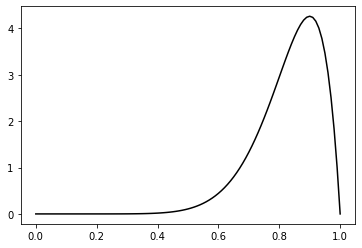

In [98]:
# YOUR CODE HERE
beta_posterior = beta_prior.updated(9, 10)
beta_posterior.plot()

### Experimenting with different predictors

Next, we want to see the predictors in action. First, the code below creates a list of ten predictors, using the three classes defined above. We'll investigate their behaviour on several different values of the true probability of getting heads. These probabilities are defined below by `true_rs = [0, .3, .5, 2/3, .75, .999]`.

Note that the final predictor in the list, `BetaPriorPredictor(0, 0)`, doesn't satisfy the constraints for being a proper Beta prior: that requires $\alpha > 0$ and $\beta > 0$. The problem is in the normalisation constant, which is undefined in this case. As we've seen, we can often get away with ignoring the normalisation constant, and by carrying this a bit further, we can use this unnormalised distribution as a prior in Bayes' theorem. Such a thing is called a *degenerate prior*. Often (but not always), the posterior we find will be a proper distribution again.

In [ ]:
# Create a list of predictors to be compared.

predictors = [MaximumLikelihoodPredictor()]

prior = DiscretePriorPredictor()
prior.probability_for_r[1/3] = 1/2
prior.probability_for_r[2/3] = 1/2
predictors.append(prior)

prior = DiscretePriorPredictor()
prior.probability_for_r[1/3] = 1/3
prior.probability_for_r[1/2] = 1/3
prior.probability_for_r[2/3] = 1/3
predictors.append(prior)

prior = DiscretePriorPredictor()
prior.probability_for_r[0] = 1/2
prior.probability_for_r[1] = 1/2
predictors.append(prior)

prior = DiscretePriorPredictor()
for r in np.linspace(0, 1, 11):
    prior.probability_for_r[r] = 1/11
predictors.append(prior)

prior = DiscretePriorPredictor()
for r in np.linspace(0, 1, 101):
    prior.probability_for_r[r] = 1/101
predictors.append(prior)

prior = BetaPriorPredictor(1, 1)
predictors.append(prior)

prior = BetaPriorPredictor(3, 3)
predictors.append(prior)

prior = BetaPriorPredictor(.5, .5)
predictors.append(prior)

prior = BetaPriorPredictor(0, 0)
predictors.append(prior)

true_rs = [0, .3, .5, 2/3, .75, .999]

For each combination of a predictor and a value $r_\text{true}$ from `true_rs`, we will do the following experiment. We'll sample some training data (100 coin flips) and compute an updated predictor using these data. For the Bayesian predictors, this comes down to computing the posterior distribution. Then we'll sample some test data (again 100 points). For both the training and the test data, the true probability of getting heads on each flip is given by $r_\text{true}$.

Now we want to evaluate how well the predictor does at predicting the test data. There are several ways to measure this. We'll try two different ones: the *logarithmic loss* and the *logarithmic regret*.

The **logarithmic loss** is something you may have seen before in other places. For instance, logistic regression is training to minimise this loss, and it's also one of the most popular choices when training neural networks for binary classification problems (there you may have seen it under the name "cross entropy"). Suppose the predictor assigns probability $\hat{r}$ to the outcome heads for a new coin flip $Y_\text{new}$, and that a new flip actually comes out as $y_\text{new}$ (1 for heads, 0 for tails). Then the logarithmic loss of this prediction is
$$-\log P_{\hat{r}} ( Y_\text{new} = y_\text{new} ).$$
In other words, if the coin in the test data came up heads, the loss is $-\log (\hat{r})$; if it came up tails, the loss is $-\log (1 - \hat{r})$.

The logarithm of 1 is 0, and as $x$ goes down to $0$, $\log(x)$ goes down to $-\infty$. So we see that the logarithmic loss is a small positive number if the outcome of the test data point was something the predictor thought was probably going to happen. But if something happens that the predictor thought would happen only with a small probability, the logarithmic loss will be larger.

The test set consists of 100 coin flips, and the loss on the test data is the *sum* of the losses of all these coin flips.

*Implementation note 1*: because the logarithm of 0 is minus infinity, write your code in such a way that if no flip happened in the test data for which the predicted probability was 0, then $\log(0)$ isn't called.

*Implementation note 2*: to compute logarithms, use `np.log` (not `math.log`). The advantage of `np.log` here is that if it does encounter a $\log(0)$, it gives a warning and allows the rest of the experiment to continue, while `math.log` would give an error and stop your code from running further.

One issue with logarithmic loss (or any loss, for that matter) is, that it's easier for predictors to get low average losses if $r_\text{true}$ is close to 0 or 1, but much harder if it's closer to 0.5. To make the comparisons between experiments more fair, we can look at the **regret** corresponding to the loss, so logarithmic regret in our case. The regret equals the loss of a predictor *minus* the loss of an ideal predictor that already knew the value $r_\text{true}$. In other words, the ideal predictor uses $r_\text{true}$ in the place where other predictors use $\hat{r}$. By comparing our predictor's loss to the loss even a clairvoyant predictor would obtain, we'll get numbers that are more meaningful when different values of $r_\text{true}$ are involved.

Like with the losses, the regret on the test data is the *sum* of the regrets of the individual coin flips.

**Task 9** (1.5 points): For each combination of predictor and $r_\text{true}$, repeat this process 100 times (including getting new training and new test data every time), and store the following in three NumPy arrays:

* The average loss;

* The average regret;

* The average marginal likelihood of the *training data* (don't use the test data for this one!)

(All averages are over the 100 repeats of the same experiment.)

In [ ]:
num_pred = len(predictors)
num_rs = len(true_rs)
num_repeats = 100
N_train = 100
N_test = 100
average_losses = np.zeros((num_pred, num_rs))
average_regrets = np.zeros((num_pred, num_rs))
average_marginal_likelihoods = np.zeros((num_pred, num_rs))

# YOUR CODE HERE

**Question 10** (2 points + 1 bonus point): Now analyse the results of your experiment. Answer at least the following questions:

* For each combination of predictor and $r_\text{true}$ that gives `inf` or `nan` loss, explain why the average loss isn't finite.

* What are the strengths and weaknesses of the different predictors? In a situation where you don't know anything about $r_\text{true}$ beforehand, which priors would you recommend, and which not?

* BONUS: Look at the marginal likelihoods, say something about model selection

You can accompany your answer by additional code that produces tables or figures.

*YOUR ANSWER HERE*

In [ ]:
# YOUR CODE HERE

    
---

<br>
<br>

**Remember: Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**